In [1]:
import sys

project_root = '/home/20230765/src'
if project_root not in sys.path:
    sys.path.append(project_root)
    
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from retrieval.pipeline_re_sd import ReSDPipeline
import torch
import json
from retrieval.trajectory import generate_trajectory, save_trajectory, retrieve_nearest_neigbours, generate_trajectory_from_latents
from retrieval.knowledge_base import create_kb, clean_kb
from metrics.metrics import pick_score, clip_score, fid_score, inception_score
import h5py
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import faiss
import pandas as pd
import textwrap
from IPython.display import clear_output
import matplotlib.gridspec as gridspec
from pycocotools.coco import COCO
from PIL import Image
import requests
from concurrent.futures import ThreadPoolExecutor
import io
import time


### Trajectories generation

In [ ]:
pipe = AutoPipelineForText2Image.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5",
    torch_dtype=torch.float16,
    variant="fp16")


json_path = "../data/generated_data/prompts/raw_prompts.json"
with open(json_path, "r") as f:
    prompts = json.load(f)

for prompt in tqdm(prompts):
    torch.cuda.empty_cache()
    generation = generate_trajectory(
        prompt=prompt,
        pipeline=pipe,
        device="cuda",
        num_inference_steps=30,
        scheduler=DDIMScheduler
    )
    save_trajectory(
        trajectory=generation[0],
        prompt=generation[1],
        trajectory_filename="../data/generated_data/raw_trajectories",
        prompt_filename="../data/generated_data/raw_prompts",
    )
    del generation

- Ideas to explore - how different are the neigbours with decreasing PCA size
- How differnt are the neighbours if we move key value
- How different are the neighbours if we create more detailed combined keys (like combination of multiple trajectory steps)
- How the quality of generation is affected by the size of KB (if I can have some better size KB)
- Experiment with different schedulers, models (before KB generation)
- Idea of training intermediate model f(key, nearest_neigbours_keys, value) = true value

### Key compression and NN retrieval

In [2]:
key_margin_steps=0
value_margin_steps=20

trajectory_path="../data/generated_data/coco_trajectories.h5"
prompts_from_path="../data/generated_data/coco_prompts.jsonl"

num_trajectories = 10000

np.random.seed(42)
query_set = np.random.choice(
    np.arange(0, num_trajectories), size=2000, replace=False
)
key_set = list(set(np.arange(0, num_trajectories)) - set(query_set))


In [3]:
# testing config
config= [
    {
        "use_pca": True,
        "embedding_dim": 2,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 4,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 16,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": False,
    },
    {
        "use_pca": True,
        "embedding_dim": 256,
        "use_pq": False,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 8,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 16,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 32,
        "n_pq_centroids": 32,
    },
    {
        "use_pq": True,
        "n_pq_subvectors": 64,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 8,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 16,
        "n_pq_centroids": 32,
    },
    {
        "use_pca": True,
        "embedding_dim": 64,
        "use_pq": True,
        "n_pq_subvectors": 64,
        "n_pq_centroids": 32,
    },
]

#### Reference KB

In [4]:
kb_path="../data/reference_knowledge_base/coco_knowledge_base.h5"
faiss_index_path="../data/reference_knowledge_base/coco_faiss_index.bin"
prompts_to_path="../data/reference_knowledge_base/coco_prompts.json"

In [5]:
# clean_kb(
#         kb_path=kb_path,
#         faiss_index_path=faiss_index_path,
#         prompts_path=prompts_to_path,
#     )

In [12]:
create_kb(
    key_margin_steps=key_margin_steps,
    value_margin_steps=value_margin_steps,
    trajectory_path=trajectory_path,
    kb_path=kb_path,
    faiss_index_path=faiss_index_path,
    prompts_from_path=prompts_from_path,
    prompts_to_path=prompts_to_path,
)

0it [00:00, ?it/s]

2000it [04:16,  7.79it/s]


In [ ]:
reference_times = []
for i in range(10):
    with h5py.File(trajectory_path, "r") as trajectory_file:
        traj_names = list(trajectory_file.keys())
        reference_neighbours_list = []
        reference_distances_list = []
        reference_time = 0
        for query in tqdm(query_set):
            query = trajectory_file[traj_names[query]][key_margin_steps]
            neighbours, timing = retrieve_nearest_neigbours(
                query_array=query,
                num_neighbours=11,
                index_path=faiss_index_path,
                kb_path=kb_path
            )    
            
            reference_neighbours_list.append([int(neighbour[2]) for neighbour in neighbours][1:])
            reference_distances_list.append([neighbour[1] for neighbour in neighbours][1:])
            reference_time += timing
            
    reference_time /= len(query_set)
    print(f"Reference time: {reference_time}")  
    reference_times.append(reference_time)
reference_times

#### KB testing

In [24]:
kb_path="../data/knowledge_base/knowledge_base.h5"
faiss_index_path="../data/knowledge_base/faiss_index.bin"
prompts_to_path="../data/knowledge_base/prompts.json"

use_pca = True
pca_path="../data/knowledge_base/compression.pkl"

In [7]:
dim_neighbours = []
avg_times = []
for cfg in tqdm(config):
    create_kb(
        key_margin_steps=key_margin_steps,
        value_margin_steps=value_margin_steps,
        trajectory_path=trajectory_path,
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_from_path=prompts_from_path,
        prompts_to_path=prompts_to_path,
        pca_path=pca_path,
        **cfg,
        
    )
    # clean queries
    with h5py.File(kb_path, "a") as kb_file:
        for query in query_set:
            del kb_file[str(query)]
            
    #remove ids
    index = faiss.read_index(faiss_index_path)
    index.remove_ids(query_set)
    faiss.write_index(index, faiss_index_path)
    
    
    
    # find neigbours
    avg_times_list = []
    for i in range(1):
        neighbours_list = []
        timing = 0
        with h5py.File(trajectory_path, "r") as trajectory_file:
            traj_names = list(trajectory_file.keys())
            for query in tqdm(query_set):
                query = trajectory_file[traj_names[query]][key_margin_steps]
                if "use_pca" in cfg.keys() and cfg["use_pca"] == True:
                    pca = pickle.load(open(pca_path, "rb"))
                    start_pca = time.time()
                    query = pca.transform(query.reshape(1, -1)).squeeze()
                    end_pca = time.time()
                    elapsed_pca = end_pca - start_pca
                    timing += elapsed_pca
                neighbours, time_search = retrieve_nearest_neigbours(
                    query_array=query,
                    num_neighbours=10,
                    index_path=faiss_index_path,
                    kb_path=kb_path
                )
                neighbours_list.append([int(neighbour[2]) for neighbour in neighbours])
                timing += time_search
                # print(f"Query took {np.round(time_search, 5)} seconds")
        avg_times_list.append(timing / len(query_set))
        print(f"Avg time: {timing / len(query_set)}")
    avg_times.append(avg_times_list)
    dim_neighbours.append(neighbours_list)
    
    clean_kb(
        kb_path=kb_path,
        faiss_index_path=faiss_index_path,
        prompts_path=prompts_to_path,
        compression_path=pca_path if "use_pca" in cfg.keys() and cfg["use_pca"] ==True else None,
    )


  0%|          | 0/12 [00:00<?, ?it/s]

Fitting PCA...


10000it [00:27, 369.80it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.00019496309757232667
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


10000it [00:27, 366.69it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.00016767096519470216
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


10000it [00:28, 354.80it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0002261573076248169
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


10000it [00:30, 323.41it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0005792849063873291
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...


10000it [01:02, 161.20it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0028254202604293824
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Training PQ index...


10000it [00:29, 336.87it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.00034424948692321776
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


10000it [00:29, 333.99it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0005121914148330689
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


10000it [00:31, 322.22it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0008659164905548096
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Training PQ index...


10000it [00:31, 318.05it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0014717782735824585
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, None
Fitting PCA...
Training PQ index...


10000it [00:33, 294.55it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0006493116617202759
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...
Training PQ index...


10000it [00:33, 294.85it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0007553102970123292
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl
Fitting PCA...
Training PQ index...


10000it [00:35, 283.63it/s]


  0%|          | 0/2000 [00:00<?, ?it/s]

Avg time: 0.0014932304620742798
Removed ../data/knowledge_base/knowledge_base.h5, ../data/knowledge_base/faiss_index.bin, ../data/knowledge_base/prompts.json, ../data/knowledge_base/compression.pkl


In [10]:
dim_neighbours.append(reference_neighbours_list)
avg_times.append(reference_times)

In [16]:
labels=[
        'PCA=2',
        'PCA=4',
        'PCA=16',
        'PCA=64',
        'PCA=256',
        'PQ=8x32',
        'PQ=16x32',
        'PQ=32x32',
        'PQ=64x32',
        'PCA=64\nPQ=8x32',
        'PCA=64\nPQ=16x32',
        'PCA=64\nPQ=64x32',
        "Reference"
        ]

/tmp/ipykernel_1686094/3491607603.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(


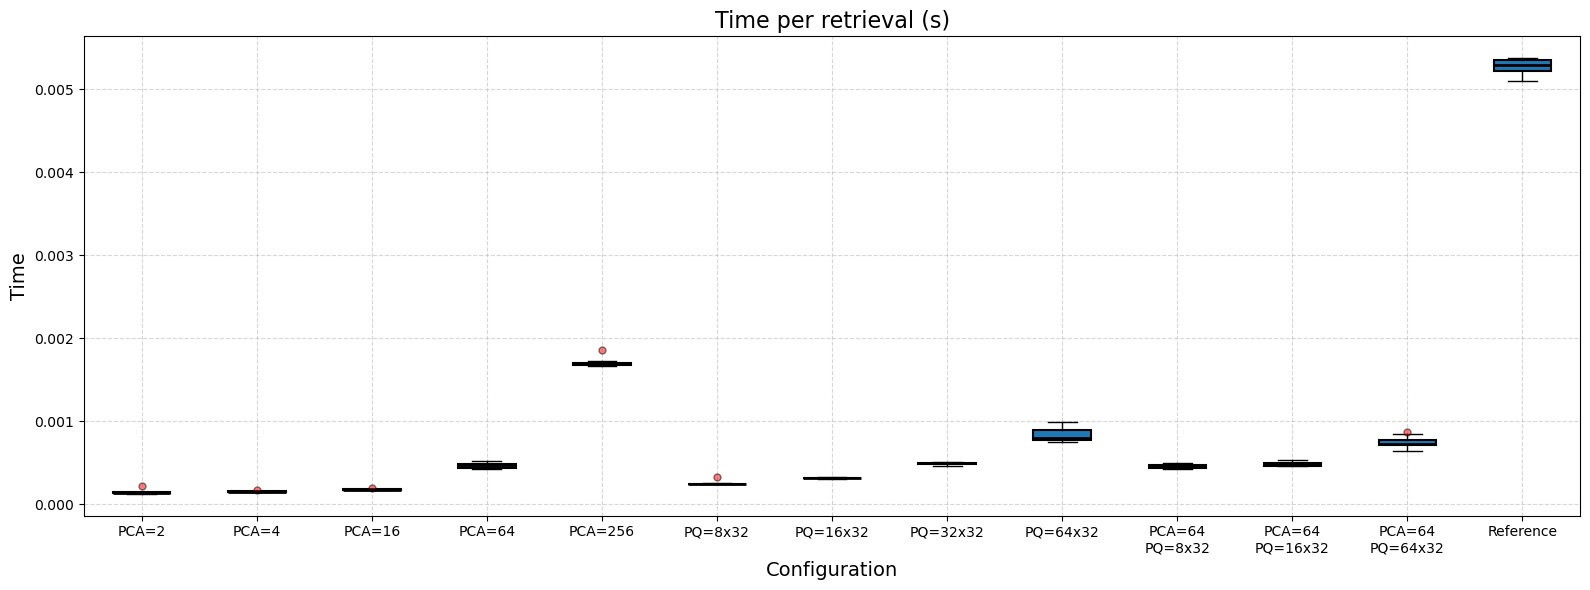

In [17]:
fig, ax = plt.subplots(figsize=(16, 6))

# Create boxplot
box = ax.boxplot(
    avg_times,
    labels=labels,
    patch_artist=True,   # This is important for color filling
    medianprops=dict(color="black", linewidth=2),
    boxprops=dict(edgecolor="black", linewidth=1.5),
    whiskerprops=dict(color="black", linewidth=1),
    capprops=dict(color="black", linewidth=1),
    flierprops=dict(markerfacecolor="red", marker="o", markersize=5, alpha=0.5)
)

# Plot settings
plt.title("Time per retrieval (s)", fontsize=16)
plt.xlabel("Configuration", fontsize=14)
plt.ylabel("Time", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.xticks(rotation=90)
plt.show()


In [19]:
plt.figure(figsize=(16, 8))
markers = ['o', 's', '^', 'v', 'D', '*', 'X', 'P', 'H', '8']

precision_table = {} 

for k in range(1, 11):
    precision_at_k = np.zeros(len(dim_neighbours)-1)
    for i in range(len(query_set)):
        neighbours_comparison = [dim[i] for dim in dim_neighbours]
        for j in range(len(neighbours_comparison)-1):
            precision_at_k[j] += len(set(neighbours_comparison[j][:k]) & set(neighbours_comparison[-1][:k])) / k

    precision_values = precision_at_k / len(query_set)

    precision_table[f"Precision@{k}"] = precision_values
    plt.plot(
        labels[:-1],
        precision_values,
        marker=markers[k-1],
        linestyle='--',
        linewidth=2,
        label=f"Precision@{k}"
    )

# Plot settings
plt.title("Precision@k", fontsize=16)
plt.xlabel("Embedding dimension", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Top-k", fontsize=10, title_fontsize=12)
plt.tight_layout()
plt.xticks(rotation=90)  # Rotate 60 degrees

plt.show()

precision_df = pd.DataFrame(precision_table, index=[str(config[i]) for i in range(len(config))])



In [20]:
# Time df
df = pd.DataFrame(
    {
        "Time (s)": avg_times,
        "Configuration": [str(config[i]) for i in range(len(config))] + ["Reference"]
    }
).round(5)
df = df.set_index("Configuration")
df.to_csv("../data/results/time_key-margin=0_dataset-size=2000.csv")

In [21]:
import ast
df = pd.read_csv("../data/results/time_key-margin=0_dataset-size=2000.csv")
df["Time (s)"].apply(ast.literal_eval)[0]

[0.00014011263847351073,
 0.00012887239456176757,
 0.0001279151439666748,
 0.00013692498207092284,
 0.0001414203643798828,
 0.00012813329696655272,
 0.00013124465942382813,
 0.0001237523555755615,
 0.0002132415771484375,
 0.00012678265571594238]

In [ ]:
precision_df.to_csv("../data/results/precision@k_key-margin=0_dataset-size=2000.csv")

In [ ]:
with open("../data/results/neighbours_key-margin=0_dataset-size=2000.json", "w") as f:
    json.dump(dim_neighbours, f, indent=4)


### Generation from retrieved

In [5]:
prompts = json.load(open(prompts_to_path, "r"))

In [6]:
pipe = ReSDPipeline.from_pretrained(
    "stable-diffusion-v1-5/stable-diffusion-v1-5", torch_dtype=torch.float16
    
).to("cuda:1")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
with open("../data/results/coco-neighbours_key-margin=0_dataset-size=10000.json") as f:
    dim_neighbours = json.load(f)

In [11]:
with h5py.File(trajectory_path, "r") as trajectory_file:
    traj_names = list(trajectory_file.keys())

In [12]:
value_margin_steps = 20
config_index = 3
query_index = 109
neighbour_num = 0

In [13]:
neighbours = dim_neighbours[config_index][query_index]
with h5py.File(trajectory_path, "r") as trajectory_file:
    neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-(value_margin_steps+1)]
    last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
    last_neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-1]


#### Demo

In [ ]:
value_magins = [25, 20, 15]
query_indices = [1,2,3,4] #[3,4,7,16,49,162,156,90,180,191,144,118] for syntheic dataset
config_index = 3
neighbour_num = 0

# Set up figure with one row per query

fig = plt.figure(figsize=(28, 5 * len(query_indices)))  # Height scales with rows
gs = gridspec.GridSpec(len(query_indices), 7, width_ratios=[0.8, 1, 1, 1, 1, 1, 0.8])
gs.update(hspace=0.05)  # Add space between rows

for row_idx, query_index in enumerate(query_indices):
    neighbours = dim_neighbours[config_index][query_index]
    
    with h5py.File(trajectory_path, "r") as trajectory_file:
        last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
        last_neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-1]

    img_real = pipe.decode_latent_to_image(latent=last_real_latent)
    img_neighbour = pipe.decode_latent_to_image(latent=last_neighbour_latent)

    img_real_from_neighbours = []
    for value_margin_steps in value_magins:
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-(value_margin_steps+1)]
        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompts[str(query_set[query_index])],
            latent=neighbour_latent,
            device="cuda:1",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps,
            scheduler=DDIMScheduler,
            pipeline=pipe
        )[0]
        img_real_from_neighbours.append(img_real_from_neighbour)

    # Prompts
    real_prompt_text = "\n".join(textwrap.wrap(prompts[str(query_set[query_index])], width=40))
    real_prompt = r"$\bf{Prompt:}$" + "\n" + real_prompt_text

    neighbour_prompt_text = "\n".join(textwrap.wrap(prompts[str(neighbours[neighbour_num])], width=40))
    neighbour_prompt = r"$\bf{Prompt:}$" + "\n" + neighbour_prompt_text

    # Left prompt
    ax_text_left = fig.add_subplot(gs[row_idx, 0])
    ax_text_left.axis('off')
    ax_text_left.text(0.5, 0.5, real_prompt, ha='center', va='center', fontsize=11,
                      wrap=True, multialignment='center')

    # Images
    axs = []
    for col_idx in range(1, 6):
        ax = fig.add_subplot(gs[row_idx, col_idx])
        axs.append(ax)

    axs[0].imshow(img_real)
    axs[0].set_title("Real image")
    axs[0].axis('off')

    for i in range(len(value_magins)):
        axs[i + 1].imshow(img_real_from_neighbours[i])
        axs[i + 1].set_title(f"Retrieval gen\nvalue_margin_steps={value_magins[i]}")
        axs[i + 1].axis('off')

    axs[4].imshow(img_neighbour)
    axs[4].set_title("Neighbour image")
    axs[4].axis('off')

    # Right prompt
    ax_text_right = fig.add_subplot(gs[row_idx, 6])
    ax_text_right.axis('off')
    ax_text_right.text(0.5, 0.5, neighbour_prompt, ha='center', va='center', fontsize=11,
                       wrap=True, multialignment='center')




plt.tight_layout()
clear_output()
print(query_indices)
plt.show()


[1, 2, 3, 4]


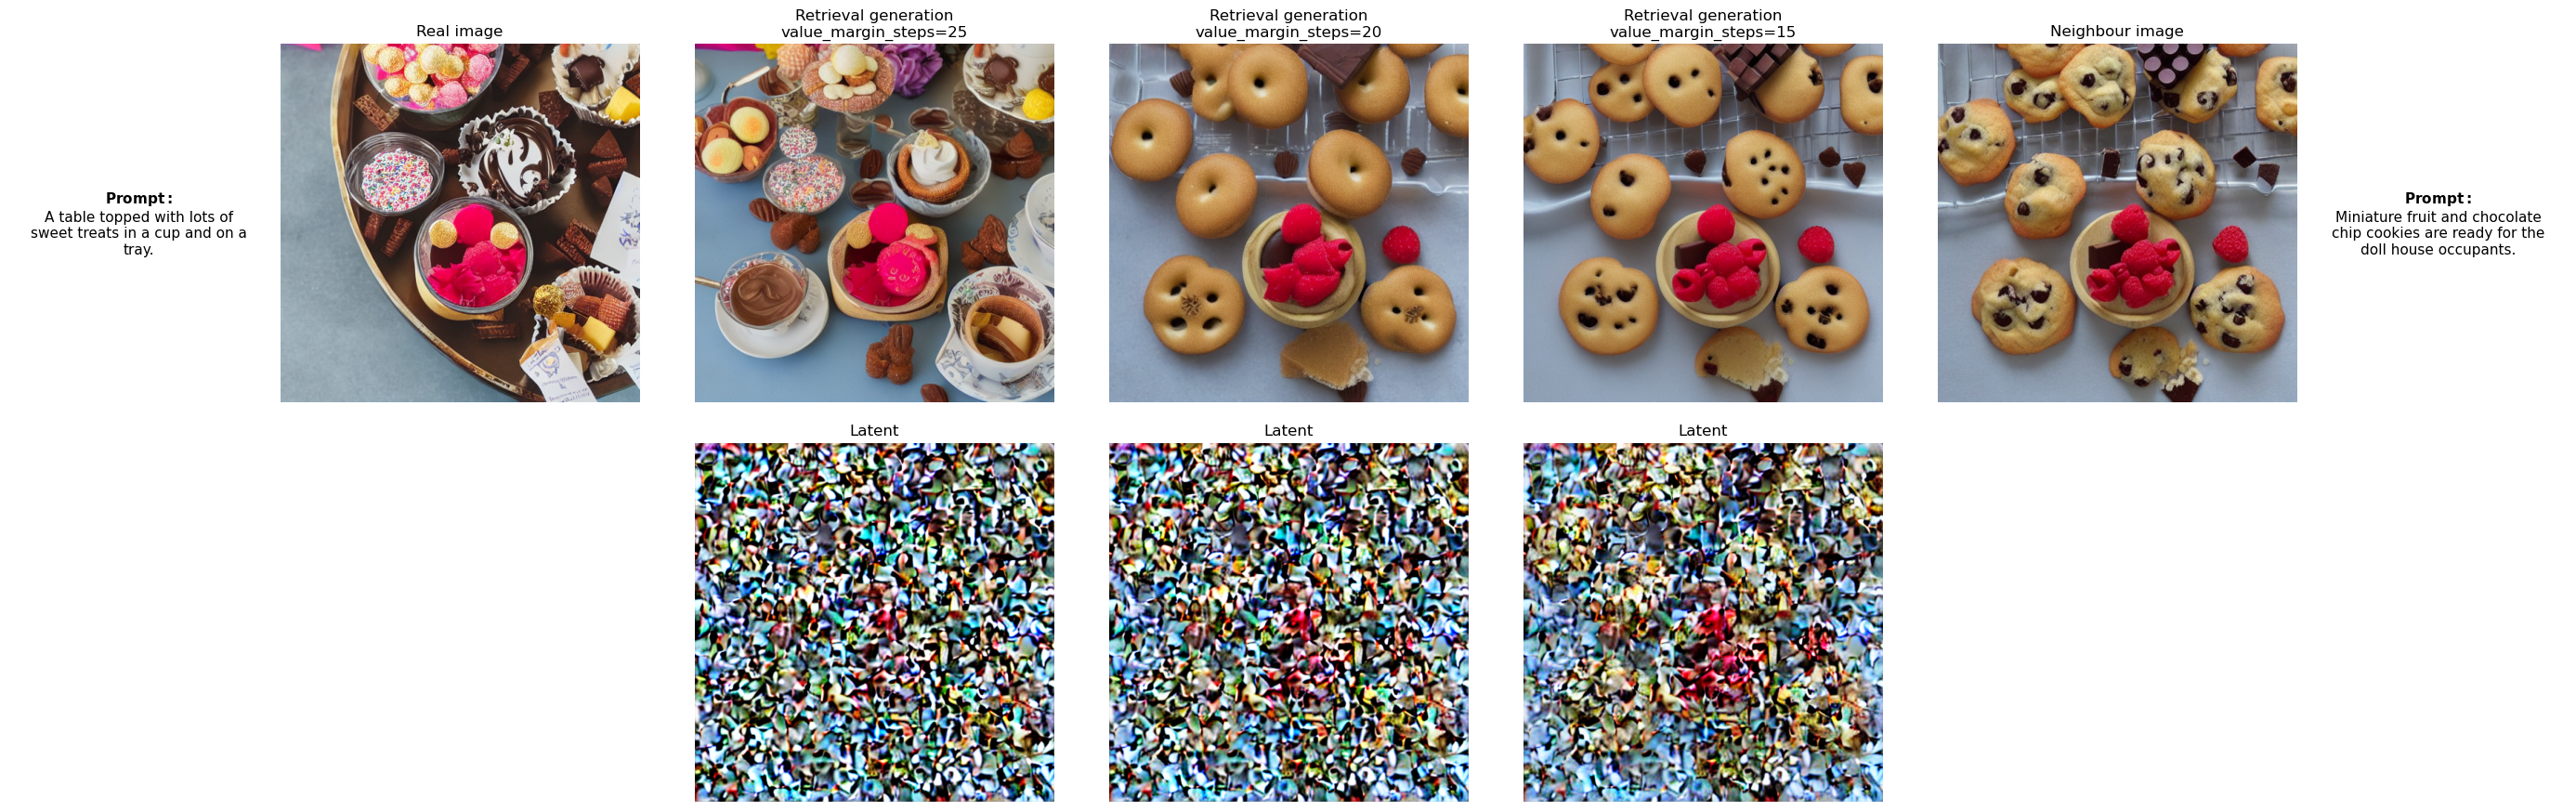

In [ ]:
config_index = 3
query_index = 19
neighbour_num = 0

neighbours = dim_neighbours[config_index][query_index]
with h5py.File(trajectory_path, "r") as trajectory_file:
    neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-(value_margin_steps+1)]
    last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
    last_neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-1]

img_real = pipe.decode_latent_to_image(
    latent=last_real_latent,
)

img_neighbour = pipe.decode_latent_to_image(
    latent=last_neighbour_latent,
)

value_magins = [25,20,15]
img_real_from_neighbours = []
latent_images = []
for value_margin_steps in value_magins:
    with h5py.File(trajectory_path, "r") as trajectory_file:
        neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-(value_margin_steps+1)]
    img_real_from_neighbour = generate_trajectory_from_latents(
        prompt=prompts[str(query_set[query_index])],
        latent=neighbour_latent,
        device="cuda:1",
        num_inference_steps=30,
        value_margin_steps=value_margin_steps,
        scheduler=DDIMScheduler,
        pipeline=pipe
    )[0]
    img_real_from_neighbours.append(img_real_from_neighbour)
    latent_images.append(pipe.decode_latent_to_image(neighbour_latent))


# Prompt text
real_prompt_text = "\n".join(textwrap.wrap(prompts[str(query_set[query_index])], width=30))
real_prompt = r"$\bf{Prompt:}$" + "\n" + real_prompt_text

neighbour_prompt_text = "\n".join(textwrap.wrap(prompts[str(neighbours[neighbour_num])], width=30))
neighbour_prompt = r"$\bf{Prompt:}$" + "\n" + neighbour_prompt_text

# Set up figure with two rows: one for images, one for latent images
clear_output()
fig = plt.figure(figsize=(28, 9))
gs = gridspec.GridSpec(2, 7, height_ratios=[1,1], width_ratios=[0.6, 1, 1, 1, 1, 1, 0.6])

# Top row: text + main images
ax_text_left = fig.add_subplot(gs[0, 0])
ax_text_left.axis('off')
ax_text_left.text(0.6, 0.5, real_prompt, ha='center', va='center', fontsize=11,
                  wrap=True, multialignment='center')

axs = []
for i in range(1, 6):
    ax = fig.add_subplot(gs[0, i])
    axs.append(ax)

axs[0].imshow(img_real)
axs[0].set_title("Real image")
axs[0].axis('off')

for i in range(len(value_magins)):
    axs[i + 1].imshow(img_real_from_neighbours[i])
    axs[i + 1].set_title(f"Retrieval generation\nvalue_margin_steps={value_magins[i]}")
    axs[i + 1].axis('off')

axs[4].imshow(img_neighbour)
axs[4].set_title("Neighbour image")
axs[4].axis('off')

ax_text_right = fig.add_subplot(gs[0, 6])
ax_text_right.axis('off')
ax_text_right.text(0.4, 0.5, neighbour_prompt, ha='center', va='center', fontsize=11,
                   wrap=True, multialignment='center')

# Bottom row: latent images under the 3 central images
for i in range(3):
    ax_latent = fig.add_subplot(gs[1, i + 2])  # columns 2, 3, 4
    ax_latent.imshow(latent_images[i])
    ax_latent.set_title("Latent")
    ax_latent.axis('off')

plt.tight_layout()
plt.show()


#### Different value_margin_steps

In [17]:
value_margin_steps = 25
config_index = 3
neighbour_num = 0
coco_flg = True

In [18]:
coco = COCO("../data/coco_annotations/instances_train2017.json")
with open('../data/generated_data/prompts/coco_prompt_to_image_id.json', "r") as f:
    coco_prompt_to_image_id = json.load(f)


loading annotations into memory...
Done (t=5.14s)
creating index...
index created!


In [19]:
def download_image(info):
    try:
        response = requests.get(info['coco_url'], timeout=10)
        response.raise_for_status()
        return Image.open(io.BytesIO(response.content)).convert("RGB")
    except Exception as e:
        print(f"Failed to download {info['id']}: {e}")
        return None

image_infos = coco.loadImgs(ids=list(coco_prompt_to_image_id.values()))

with ThreadPoolExecutor(max_workers=512) as executor: 
    images = list(tqdm(executor.map(download_image, image_infos), total=len(image_infos), desc="Downloading images"))
    coco_images_dict = {info['id']: img for info, img in zip(image_infos, images) if img is not None}


In [18]:
num_queries = len(query_set)

clips_real = []
clips_generated = []
picks = []
inceptions_real = []
inceptions_generated = []
fids = []
if coco_flg == True:
    coco_picks = []
    neighbour_coco_picks = []
    coco_clips = []
    fids_coco = []
    fids_neighbour = []
    inceptions_coco = []

cnt = 0
for value_margin_steps in tqdm([15, 20, 25, 27]):
    resulting_images = []
    pick = 0
    if coco_flg == True:
        pick_coco = 0
        pick_coco_neighbour = 0
    for query_index in tqdm(range(num_queries)):
        neighbours = dim_neighbours[config_index][query_index]
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbour_latent = trajectory_file[traj_names[neighbours[neighbour_num]]][-(value_margin_steps+1)]
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
            
        prompt = prompts[str(query_set[query_index])]


        img_real = pipe.decode_latent_to_image(
            latent=last_real_latent,
        )

        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompt,
            latent=neighbour_latent,
            device="cuda:1",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps,
            scheduler=DDIMScheduler,
            pipeline=pipe
        )[0]
        
        if coco_flg == True:
            coco_img = coco_images_dict[coco_prompt_to_image_id[prompt]].resize((512, 512))
            resulting_images.append([img_real_from_neighbour, img_real, coco_img])
        else:
            resulting_images.append([img_real_from_neighbour, img_real])
        
        
        # metrics
        pick += pick_score(
            prompt=prompt,
            images = [img_real_from_neighbour, img_real],
        )[0]  
        if coco_flg == True:
            pick_coco_neighbour += pick_score(
                prompt=prompt,
                images = [img_real_from_neighbour, coco_img],
            )[0]
            pick_coco += pick_score(
                prompt=prompt,
                images = [img_real, coco_img],
            )[0]
    real_images = [images[1] for images in resulting_images]
    generated_images = [images[0] for images in resulting_images]
    
    clip_real = clip_score(
        images=real_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )
    clip_generated = clip_score(
        images=generated_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )

    fid = fid_score(
        real_images=real_images[:num_queries],
        generated_images=generated_images[:num_queries],
    )

    inception_real = inception_score(images=real_images)
    inception_generated = inception_score(images=generated_images)

    print("FID gen vs retrieval: ", fid)
    print("Inception score real: ", inception_real)
    print("Inception score generated: ", inception_generated)
    print("CLIP score real: ", clip_real)
    print("CLIP score generated: ", clip_generated)
    print("Pick score: ", pick/(query_index+1))

    fids.append(fid)
    inceptions_real.append(inception_real)
    inceptions_generated.append(inception_generated)
    clips_real.append(clip_real)
    clips_generated.append(clip_generated)
    picks.append(pick/(query_index+1))

    if coco_flg == True:
        
        coco_images = [images[2] for images in resulting_images]
        clip_coco = clip_score(
            images=coco_images,
            prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
        )
        fid_coco = fid_score(
            real_images=coco_images,
            generated_images=real_images[:num_queries],
        )
        fid_neighbour = fid_score(
            real_images=coco_images,
            generated_images=generated_images[:num_queries],
        )
        inception_coco = inception_score(images=coco_images)
        print("FID gen vs coco: ", fid_coco)
        print("FID retrieval vs coco: ", fid_neighbour)
        print("Inception score coco: ", inception_coco)
        print("CLIP score coco: ", clip_coco)
        print("Pick score gen vs coco: ", pick_coco/(query_index+1))
        print("Pick score retrieval vs coco: ", pick_coco_neighbour/(query_index+1))
        fids_coco.append(fid_coco)
        fids_neighbour.append(fid_neighbour)
        inceptions_coco.append(inception_coco)
        coco_clips.append(clip_coco)
        coco_picks.append(pick_coco/(query_index+1))
        neighbour_coco_picks.append(pick_coco_neighbour/(query_index+1))


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
/home/20230765/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*arg

FID gen vs retrieval:  27.850069046020508
Inception score real:  (22.78056526184082, 2.350802183151245)
Inception score generated:  (20.10626220703125, 1.1074861288070679)
CLIP score real:  31.4385
CLIP score generated:  28.5715
Pick score:  0.31738792600220767
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  53.32146072387695
Inception score coco:  (18.880788803100586, 1.2124748229980469)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.3995284668581735


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  26.26319694519043
Inception score real:  (22.762521743774414, 1.2499902248382568)
Inception score generated:  (20.351158142089844, 1.8300145864486694)
CLIP score real:  31.4385
CLIP score generated:  29.9953
Pick score:  0.37574801785848105
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  51.97831726074219
Inception score coco:  (18.819780349731445, 1.4508696794509888)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.4608655960760079


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  23.34524917602539
Inception score real:  (22.79208755493164, 2.1211042404174805)
Inception score generated:  (21.406972885131836, 1.6751554012298584)
CLIP score real:  31.4385
CLIP score generated:  31.1147
Pick score:  0.4567004176210612
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.09101486206055
Inception score coco:  (18.873302459716797, 1.8686443567276)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5412763616591691


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  20.736610412597656
Inception score real:  (22.810598373413086, 2.267185688018799)
Inception score generated:  (22.38627815246582, 1.5564802885055542)
CLIP score real:  31.4385
CLIP score generated:  31.2271
Pick score:  0.47883388520777226
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.56191635131836
Inception score coco:  (19.000038146972656, 1.7613945007324219)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5607453922312706


In [ ]:
# import pickle
# from PIL import Image

# with open('real_images.pkl', 'wb') as f:
#     pickle.dump(real_images, f)
# with open('generated_images.pkl', 'wb') as f:
#     pickle.dump(generated_images, f)
# with open('coco_images.pkl', 'wb') as f:
#     pickle.dump(coco_images, f)
# real_images = pickle.load(open('real_images.pkl', 'rb'))
# generated_images = pickle.load(open('generated_images.pkl', 'rb'))
# coco_images = pickle.load(open('coco_images.pkl', 'rb'))


In [39]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Value Margin Steps': [15, 20, 25, 27],
    'CLIP Score Real': clips_real,
    'CLIP Score Generated': clips_generated,
    'Pick score retrieval vs gen': picks,
    'Inception Score Real': inceptions_real,
    'Inception Score Generated': inceptions_generated,
    'FID retrieval vs gen': fids,
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Value Margin Steps')

# # Save to CSV
metrics_df.to_csv('../data/results/metrics-value-margin-steps_key-margin=0_dataset-size=2000_num-neighbours=1.csv')

# Display the table
metrics_df

CLIP Score Real  CLIP Score Generated  \
Value Margin Steps                                          
15                          30.9534               29.5349   
20                          30.9534               30.0812   
25                          30.9534               30.5642   
27                          30.9534               30.7368   

                    Pick score retrieval vs gen  \
Value Margin Steps                                
15                                     0.416759   
20                                     0.451743   
25                                     0.484228   
27                                     0.491227   

                                       Inception Score Real  \
Value Margin Steps                                            
15                   (5.761147975921631, 1.075925588607788)   
20                  (5.749648094177246, 0.6142719388008118)   
25                  (5.867392063140869, 0.9334277510643005)   
27                  (5.762115955352783, 0.8956693410873413)   

                                   Inception Score Generated  \
Value Margin Steps                                             
15                  (5.5226874351501465, 0.6543694734573364)   
20                   (5.389012336730957, 0.8195964097976685)   
25                   (5.537766933441162, 1.0438597202301025)   
27                    (5.848884582519531, 0.828650951385498)   

                    FID retrieval vs gen  
Value Margin Steps                        
15                             78.769638  
20                             76.817513  
25                             69.654884  
27                             63.262337

In [20]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Value Margin Steps': [15, 20, 25, 27],
    'CLIP Score Real': clips_real,
    'CLIP Score Generated': clips_generated,
    'CLIP Score Coco': coco_clips,
    'Pick score retrieval vs gen': picks,
    'Pick score gen vs coco': coco_picks,
    'Pick score retrieval vs coco': neighbour_coco_picks,
    'Inception Score Real': inceptions_real,
    'Inception Score Generated': inceptions_generated,
    'Inception Score Coco': inceptions_coco,
    'FID retrieval vs gen': fids,
    'FID gen vs coco': fids_coco,
    'FID retrieval vs coco': fids_neighbour
    
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Value Margin Steps')

# # Save to CSV
metrics_df.to_csv('../data/results/coco-metrics-value-margin-steps-20-25-27_key-margin=0_dataset-size=20000_num-neighbours=1.csv')

# Display the table
metrics_df

CLIP Score Real  CLIP Score Generated  CLIP Score Coco  \
Value Margin Steps                                                           
15                          31.4385               28.5715          30.3002   
20                          31.4385               29.9953          30.3002   
25                          31.4385               31.1147          30.3002   
27                          31.4385               31.2271          30.3002   

                    Pick score retrieval vs gen  Pick score gen vs coco  \
Value Margin Steps                                                        
15                                     0.317388                0.579328   
20                                     0.375748                0.579328   
25                                     0.456700                0.579328   
27                                     0.478834                0.579328   

                    Pick score retrieval vs coco  \
Value Margin Steps                                 
15                                      0.399528   
20                                      0.460866   
25                                      0.541276   
27                                      0.560745   

                                        Inception Score Real  \
Value Margin Steps                                             
15                    (22.78056526184082, 2.350802183151245)   
20                  (22.762521743774414, 1.2499902248382568)   
25                   (22.79208755493164, 2.1211042404174805)   
27                   (22.810598373413086, 2.267185688018799)   

                                   Inception Score Generated  \
Value Margin Steps                                             
15                   (20.10626220703125, 1.1074861288070679)   
20                  (20.351158142089844, 1.8300145864486694)   
25                  (21.406972885131836, 1.6751554012298584)   
27                   (22.38627815246582, 1.5564802885055542)   

                                        Inception Score Coco  \
Value Margin Steps                                             
15                  (18.880788803100586, 1.2124748229980469)   
20                  (18.819780349731445, 1.4508696794509888)   
25                     (18.873302459716797, 1.8686443567276)   
27                  (19.000038146972656, 1.7613945007324219)   

                    FID retrieval vs gen  FID gen vs coco  \
Value Margin Steps                                          
15                             27.850069        51.893341   
20                             26.263197        51.893341   
25                             23.345249        51.893341   
27                             20.736610        51.893341   

                    FID retrieval vs coco  
Value Margin Steps                         
15                              53.321461  
20                              51.978317  
25                              52.091015  
27                              52.561916

ValueError: x and y must have same first dimension, but have shapes (4,) and (1,)

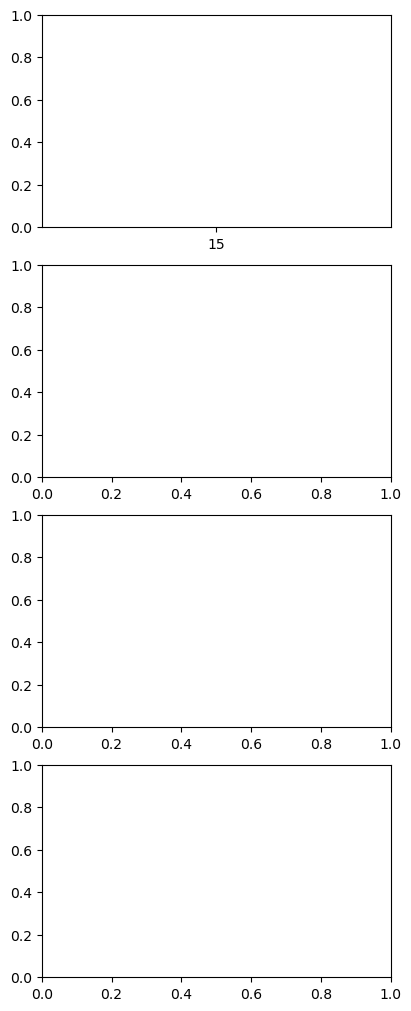

In [20]:
fig, ax = plt.subplots(nrows=4, figsize=(4, 10), dpi=100, constrained_layout=True)

# Define common properties
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's']

labels = ["15", "20", "25", "27"]

# CLIP score
ax[0].plot(
    labels,
    clips_real,
    marker=markers[0],
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="CLIP original"
)
ax[0].plot(
    labels,
    clips_generated,
    marker=markers[1],
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="CLIP retrieval"
)
if coco_flg == True:
    ax[0].plot(
        labels,
        coco_clips,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="CLIP coco"
    )
    ax[1].plot(
        labels,
        neighbour_coco_picks,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[1],
        label="Pick score retrieval vs coco"
    )
    ax[1].plot(
        labels,
        coco_picks,
        marker=markers[0],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="Pick score gen vs coco"
    )
    ax[2].plot(
        labels,
        inceptions_coco,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="Inception score coco"
    )
    ax[3].plot(
        labels,
        fids_neighbour,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[1],
        label="FID retrieval vs coco"
    )
    ax[3].plot(
        labels,
        fids_coco,
        marker=markers[0],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="FID gen vs coco"
    )

ax[0].set_title("CLIP Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[0].legend(fontsize=8)
ax[0].set_xlabel("Value Margin Steps", fontsize=8)
ax[0].set_ylabel("CLIP Score", fontsize=8)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Pick score
ax[1].plot(
    labels,
    picks,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Pick score retrieval vs gen"
)
ax[1].set_title("Pick Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[1].set_xlabel("Value Margin Steps", fontsize=8)
ax[1].set_ylabel("Pick Score", fontsize=8)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend(fontsize=8)

# Inception score
ax[2].plot(
    labels,
    inceptions_real,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Inception score original"
)
ax[2].plot(
    labels,
    inceptions_generated,
    marker='s',
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="Inception score retrieval"
)
ax[2].set_title("Inception Score vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[2].set_xlabel("Value Margin Steps", fontsize=8)
ax[2].set_ylabel("Inception Score", fontsize=8)
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].legend(fontsize=8)

# FID
ax[3].plot(
    labels,
    fids,
    marker='o',
    linestyle='-',
    linewidth=2,
    color= colors[0],
    label="FID retrieval vs gen"
)
ax[3].set_title("FID vs Value Margin Steps", fontsize=10, fontweight='bold')
ax[3].set_xlabel("Value Margin Steps", fontsize=8)
ax[3].set_ylabel("FID", fontsize=8)
ax[3].grid(True, linestyle='--', alpha=0.6)
ax[3].legend(fontsize=11)

for axis in ax:
    axis.tick_params(axis='both', labelsize=8)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontname('DejaVu Sans')
        label.set_fontsize(8)

plt.show()

#### Different amount of neighbours

In [16]:
value_margin_steps = 25
config_index = 3
neighbour_num = 0
coco_flg = True

In [20]:
num_queries = len(query_set)

clips_real = []
clips_generated = []
picks = []
inceptions_real = []
inceptions_generated = []
fids = []
if coco_flg == True:
    coco_picks = []
    neighbour_coco_picks = []
    coco_clips = []
    fids_coco = []
    fids_neighbour = []
    inceptions_coco = []
    
for neighbour_num in tqdm([0, 2, 4, 9]):
    resulting_images = []
    pick = 0
    if coco_flg == True:
        pick_coco = 0
        pick_coco_neighbour = 0
    for query_index in tqdm(range(num_queries)):
        neighbours = dim_neighbours[config_index][query_index]
        with h5py.File(trajectory_path, "r") as trajectory_file:
            neighbours_latents = [
                trajectory_file[traj_names[neighbours[j]]][-(value_margin_steps+1)]
                for j in range(neighbour_num + 1)
            ]
            neighbour_latent = np.mean(neighbours_latents, axis=0)
            last_real_latent = trajectory_file[traj_names[query_set[query_index]]][-1]
            
        prompt = prompts[str(query_set[query_index])]


        img_real = pipe.decode_latent_to_image(
            latent=last_real_latent,
        )

        img_real_from_neighbour = generate_trajectory_from_latents(
            prompt=prompt,
            latent=neighbour_latent,
            device="cuda:1",
            num_inference_steps=30,
            value_margin_steps=value_margin_steps,
            scheduler=DDIMScheduler,
            pipeline=pipe
        )[0]
        if coco_flg == True:
            coco_img = coco_images_dict[coco_prompt_to_image_id[prompt]].resize((512, 512))
            resulting_images.append([img_real_from_neighbour, img_real, coco_img])
        else:
            resulting_images.append([img_real_from_neighbour, img_real])
        
        
        # metrics
        pick += pick_score(
            prompt=prompt,
            images = [img_real_from_neighbour, img_real],
        )[0]  
        if coco_flg == True:
            pick_coco_neighbour += pick_score(
                prompt=prompt,
                images = [img_real_from_neighbour, coco_img],
            )[0]
            pick_coco += pick_score(
                prompt=prompt,
                images = [img_real, coco_img],
            )[0]
            
    real_images = [images[1] for images in resulting_images]
    generated_images = [images[0] for images in resulting_images]
    

    clip_real = clip_score(
        images=real_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )
    clip_generated = clip_score(
        images=generated_images,
        prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
    )
    
    fid = fid_score(
        real_images=real_images[:num_queries],
        generated_images=generated_images[:num_queries],
    )

    inception_real = inception_score(images=real_images)
    inception_generated = inception_score(images=generated_images)

    print("FID gen vs retrieval: ", fid)
    print("Inception score real: ", inception_real)
    print("Inception score generated: ", inception_generated)
    print("CLIP score real: ", clip_real)
    print("CLIP score generated: ", clip_generated)
    print("Pick score: ", pick/(query_index+1))
    
    fids.append(fid)
    inceptions_real.append(inception_real)
    inceptions_generated.append(inception_generated)
    clips_real.append(clip_real)
    clips_generated.append(clip_generated)
    picks.append(pick/(query_index+1))
    
    if coco_flg == True:
        
        coco_images = [images[2] for images in resulting_images]
        clip_coco = clip_score(
            images=coco_images,
            prompts=[prompts[str(query_set[i])] for i in range(num_queries)],
        )
        fid_coco = fid_score(
            real_images=coco_images,
            generated_images=real_images[:num_queries],
        )
        fid_neighbour = fid_score(
            real_images=coco_images,
            generated_images=generated_images[:num_queries],
        )
        inception_coco = inception_score(images=coco_images)
        print("FID gen vs coco: ", fid_coco)
        print("FID retrieval vs coco: ", fid_neighbour)
        print("Inception score coco: ", inception_coco)
        print("CLIP score coco: ", clip_coco)
        print("Pick score gen vs coco: ", pick_coco/(query_index+1))
        print("Pick score retrieval vs coco: ", pick_coco_neighbour/(query_index+1))
        fids_coco.append(fid_coco)
        fids_neighbour.append(fid_neighbour)
        inceptions_coco.append(inception_coco)
        coco_clips.append(clip_coco)
        coco_picks.append(pick_coco/(query_index+1))
        neighbour_coco_picks.append(pick_coco_neighbour/(query_index+1))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:308: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)
/usr/local/anaconda/lib/python3.12/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)
/home/20230765/.local/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*arg

FID gen vs retrieval:  23.34524917602539
Inception score real:  (22.78056526184082, 2.350802183151245)
Inception score generated:  (21.499197006225586, 1.9205876588821411)
CLIP score real:  31.4385
CLIP score generated:  31.1147
Pick score:  0.4567004176210612
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.09101486206055
Inception score coco:  (18.880788803100586, 1.2124748229980469)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5412763616591691


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  22.837514877319336
Inception score real:  (22.762521743774414, 1.2499902248382568)
Inception score generated:  (22.05628204345703, 1.6880426406860352)
CLIP score real:  31.4385
CLIP score generated:  31.2254
Pick score:  0.4679476080052555
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.60096740722656
Inception score coco:  (18.819780349731445, 1.4508696794509888)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5502157970145345


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  22.33795738220215
Inception score real:  (22.79208755493164, 2.1211042404174805)
Inception score generated:  (21.70033836364746, 1.5991719961166382)
CLIP score real:  31.4385
CLIP score generated:  31.2998
Pick score:  0.47494137243926526
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.49289321899414
Inception score coco:  (18.873302459716797, 1.8686443567276)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5573374002631754


  0%|          | 0/2000 [00:00<?, ?it/s]

FID gen vs retrieval:  22.70355796813965
Inception score real:  (22.810598373413086, 2.267185688018799)
Inception score generated:  (21.975683212280273, 1.7631832361221313)
CLIP score real:  31.4385
CLIP score generated:  31.2661
Pick score:  0.4755187100097537
FID gen vs coco:  51.893341064453125
FID retrieval vs coco:  52.9656982421875
Inception score coco:  (19.000038146972656, 1.7613945007324219)
CLIP score coco:  30.3002
Pick score gen vs coco:  0.5793283226620406
Pick score retrieval vs coco:  0.5586608443977311


In [30]:
fig, ax = plt.subplots(nrows=4, figsize=(4, 10), dpi=100, constrained_layout=True)

# Define common properties
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's']

labels = ['1', '3', '5', '10']

# CLIP score
ax[0].plot(
    labels,
    clips_real,
    marker=markers[0],
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="CLIP original"
)
ax[0].plot(
    labels,
    clips_generated,
    marker=markers[1],
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="CLIP retrieval"
)
if coco_flg == True:
    ax[0].plot(
        labels,
        coco_clips,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="CLIP coco"
    )
    ax[1].plot(
        labels,
        neighbour_coco_picks,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[1],
        label="Pick score retrieval vs coco"
    )
    ax[1].plot(
        labels,
        coco_picks,
        marker=markers[0],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="Pick score gen vs coco"
    )
    ax[2].plot(
        labels,
        inceptions_coco,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="Inception score coco"
    )
    ax[3].plot(
        labels,
        fids_neighbour,
        marker=markers[1],
        linestyle='-',
        linewidth=2,
        color=colors[1],
        label="FID retrieval vs coco"
    )
    ax[3].plot(
        labels,
        fids_coco,
        marker=markers[0],
        linestyle='-',
        linewidth=2,
        color=colors[2],
        label="FID gen vs coco"
    )

ax[0].set_title("CLIP Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[0].legend(fontsize=8)
ax[0].set_xlabel("Number of neighbours", fontsize=8)
ax[0].set_ylabel("CLIP Score", fontsize=8)
ax[0].grid(True, linestyle='--', alpha=0.6)

# Pick score
ax[1].plot(
    labels,
    picks,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Pick score retrieval vs gen"
)
ax[1].set_title("Pick Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[1].set_xlabel("Number of neighbours", fontsize=8)
ax[1].set_ylabel("Pick Score", fontsize=8)
ax[1].grid(True, linestyle='--', alpha=0.6)
ax[1].legend(fontsize=8)

# Inception score
ax[2].plot(
    labels,
    inceptions_real,
    marker='o',
    linestyle='-',
    linewidth=2,
    color=colors[0],
    label="Inception score original"
)
ax[2].plot(
    labels,
    inceptions_generated,
    marker='s',
    linestyle='-',
    linewidth=2,
    color=colors[1],
    label="Inception score retrieval"
)
ax[2].set_title("Inception Score vs Number of neighbours", fontsize=10, fontweight='bold')
ax[2].set_xlabel("Number of neighbours", fontsize=8)
ax[2].set_ylabel("Inception Score", fontsize=8)
ax[2].grid(True, linestyle='--', alpha=0.6)
ax[2].legend(fontsize=8)

# FID
ax[3].plot(
    labels,
    fids,
    marker='o',
    linestyle='-',
    linewidth=2,
    color= colors[0],
    label="FID retrieval vs gen"
)
ax[3].set_title("FID vs Number of neighbours", fontsize=10, fontweight='bold')
ax[3].set_xlabel("Number of neighbours", fontsize=8)
ax[3].set_ylabel("FID", fontsize=8)
ax[3].grid(True, linestyle='--', alpha=0.6)
ax[3].legend(fontsize=11)

for axis in ax:
    axis.tick_params(axis='both', labelsize=8)
    for label in (axis.get_xticklabels() + axis.get_yticklabels()):
        label.set_fontname('DejaVu Sans')
        label.set_fontsize(8)

plt.show()

In [51]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Num Neighbours': [1, 3, 5, 10],
    'CLIP Score Real': clips_real,
    'CLIP Score Generated': clips_generated,
    'Pick score retrieval vs gen': picks,
    'Inception Score Real': inceptions_real,
    'Inception Score Generated': inceptions_generated,
    'FID retrieval vs gen': fids,
    
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Num Neighbours')

# # Save to CSV
metrics_df.to_csv('../data/results/metrics-num-neighbours_key-margin=0_dataset-size=2000_value-margin-steps=25.csv')

# Display the table
metrics_df

CLIP Score Real  CLIP Score Generated  \
Num Neighbours                                          
1                       30.9534               30.5642   
3                       30.9534               30.5701   
5                       30.9534               30.7412   
10                      30.9534               30.5074   

                Pick score retrieval vs gen  \
Num Neighbours                                
1                                  0.484228   
3                                  0.486300   
5                                  0.493373   
10                                 0.496494   

                                   Inception Score Real  \
Num Neighbours                                            
1               (5.629772663116455, 0.7434278726577759)   
3                (5.722982883453369, 1.044575572013855)   
5                (6.000770568847656, 1.194790005683899)   
10              (5.906458854675293, 1.3358405828475952)   

                              Inception Score Generated  FID retrieval vs gen  
Num Neighbours                                                                 
1               (5.719306945800781, 0.8900483250617981)             69.654884  
3               (5.620270252227783, 0.9135170578956604)             67.758812  
5                 (5.69653844833374, 1.161196231842041)             67.157829  
10                 (5.810286998748779, 1.0231853723526)             67.625145

In [21]:
# Create DataFrame with metrics
metrics_df = pd.DataFrame({
    'Num Neighbours': [1, 3, 5, 10],
    'CLIP Score Real': clips_real,
    'CLIP Score Generated': clips_generated,
    'CLIP Score Coco': coco_clips,
    'Pick score retrieval vs gen': picks,
    'Pick score gen vs coco': coco_picks,
    'Pick score retrieval vs coco': neighbour_coco_picks,
    'Inception Score Real': inceptions_real,
    'Inception Score Generated': inceptions_generated,
    'Inception Score Coco': inceptions_coco,
    'FID retrieval vs gen': fids,
    'FID gen vs coco': fids_coco,
    'FID retrieval vs coco': fids_neighbour
    
})

# Set Value Margin Steps as index
metrics_df = metrics_df.set_index('Num Neighbours')

# # Save to CSV
metrics_df.to_csv('../data/results/coco-metrics-num-neighbours_key-margin=0_dataset-size=10000_value-margin-steps=25.csv')

# Display the table
metrics_df

CLIP Score Real  CLIP Score Generated  CLIP Score Coco  \
Num Neighbours                                                           
1                       31.4385               31.1147          30.3002   
3                       31.4385               31.2254          30.3002   
5                       31.4385               31.2998          30.3002   
10                      31.4385               31.2661          30.3002   

                Pick score retrieval vs gen  Pick score gen vs coco  \
Num Neighbours                                                        
1                                  0.456700                0.579328   
3                                  0.467948                0.579328   
5                                  0.474941                0.579328   
10                                 0.475519                0.579328   

                Pick score retrieval vs coco  \
Num Neighbours                                 
1                                   0.541276   
3                                   0.550216   
5                                   0.557337   
10                                  0.558661   

                                    Inception Score Real  \
Num Neighbours                                             
1                 (22.78056526184082, 2.350802183151245)   
3               (22.762521743774414, 1.2499902248382568)   
5                (22.79208755493164, 2.1211042404174805)   
10               (22.810598373413086, 2.267185688018799)   

                               Inception Score Generated  \
Num Neighbours                                             
1               (21.499197006225586, 1.9205876588821411)   
3                (22.05628204345703, 1.6880426406860352)   
5                (21.70033836364746, 1.5991719961166382)   
10              (21.975683212280273, 1.7631832361221313)   

                                    Inception Score Coco  \
Num Neighbours                                             
1               (18.880788803100586, 1.2124748229980469)   
3               (18.819780349731445, 1.4508696794509888)   
5                  (18.873302459716797, 1.8686443567276)   
10              (19.000038146972656, 1.7613945007324219)   

                FID retrieval vs gen  FID gen vs coco  FID retrieval vs coco  
Num Neighbours                                                                
1                          23.345249        51.893341              52.091015  
3                          22.837515        51.893341              52.600967  
5                          22.337957        51.893341              52.492893  
10                         22.703558        51.893341              52.965698